In [5]:
#import load_data
#from load_data import DataGenerator
#from load_data import get_images, image_file_to_array
import os
import imageio
import numpy as np

In [20]:
def get_images(paths, labels, nb_samples=None, shuffle=True):
    """
    Takes a set of character folders and labels and returns paths to image files
    paired with labels.
    Args:
        paths: A list of character folders
        labels: List or numpy array of same length as paths
        nb_samples: Number of images to retrieve per character
    Returns:
        List of (label, image_path) tuples
    """
    if nb_samples is not None:
        sampler = lambda x: np.random.choice(x, nb_samples)
    else:
        sampler = lambda x: x
    images_labels = [(i, os.path.join(path, image))
                     for i, path in zip(labels, paths)
                     for image in sampler(os.listdir(path))]
    if shuffle:
        np.random.shuffle(images_labels)
    return images_labels


def image_file_to_array(filename, dim_input):
    """
    Takes an image path and returns numpy array
    Args:
        filename: Image filename
        dim_input: Flattened shape of image
    Returns:
        1 channel image
    """
    #image = misc.imread(filename)
    image = imageio.imread(filename)
    image = image.reshape([dim_input])
    image = image.astype(np.float32) / 255.0
    image = 1.0 - image
    return image

In [21]:
class DataGenerator(object):
    """
    Data Generator capable of generating batches of Omniglot data.
    A "class" is considered a class of omniglot digits.
    """

    def __init__(self, num_classes, num_samples_per_class, config={}):
        """
        Args:
            num_classes: Number of classes for classification (K-way)
            num_samples_per_class: num samples to generate per class in one batch
            batch_size: size of meta batch size (e.g. number of functions)
        """
        self.num_classes = num_classes
        self.num_samples_per_class = num_samples_per_class
        

        config = {'sad':''}

        data_folder = config.get('data_folder', './omniglot_resized')
        self.img_size = config.get('img_size', (28, 28))

        self.dim_input = np.prod(self.img_size)
        self.dim_output = self.num_classes

        character_folders = [os.path.join(data_folder, family, character)
                             for family in os.listdir(data_folder)
                             if os.path.isdir(os.path.join(data_folder, family))
                             for character in os.listdir(os.path.join(data_folder, family))
                             if os.path.isdir(os.path.join(data_folder, family, character))]

        np.random.seed(42)
        np.random.shuffle(character_folders)
        num_val = 100
        num_train = 1100
        self.metatrain_character_folders = character_folders[: num_train]
        self.metaval_character_folders = character_folders[
            num_train:num_train + num_val]
        self.metatest_character_folders = character_folders[
            num_train + num_val:]
        print("Data generator initialized. Shape: [B, {}, {}, 784]".format(self.num_samples_per_class, self.num_classes))

    def sample_batch(self, batch_type, batch_size=1):#, k_samples=1, n_classes=5):
        """
        Samples a batch for training, validation, or testing
        Args:
            batch_type: train/val/test
        Returns:
            A a tuple of (1) Image batch and (2) Label batch where
            image batch has shape [B, K, N, 784] and label batch has shape [B, K, N, N]
            where B is batch size, K is number of samples per class, N is number of classes
        """
        n_classes  = self.num_classes
        k_samples  = self.num_samples_per_class
        
        if batch_type == "train":
            folders = self.metatrain_character_folders
        elif batch_type == "val":
            folders = self.metaval_character_folders
        else:
            folders = self.metatest_character_folders

        #############################
        #### YOUR CODE GOES HERE ####
        pixels = 28*28
        all_image_batches = np.ndarray((batch_size, k_samples, n_classes, pixels))
        all_label_batches = np.ndarray((batch_size, k_samples, n_classes, n_classes))
        #print("all_image_batches shape: ", all_image_batches.shape)
        for b in range(batch_size):
            # Take N samples from all alphabet folders
            sample_paths  = np.random.choice(folders, n_classes)
            sample_labels = [os.path.basename(os.path.split(family)[0]) for family in sample_paths]
            images_labels = get_images(sample_paths, sample_labels, k_samples)
            
            # TODO: COrrect use of dimension
            count = 0
            for k in range(k_samples):
                for n in range(n_classes):
                    #print(images_labels[count][1])
                    all_image_batches[b, k, n, :] = image_file_to_array(filename=images_labels[count][1], dim_input=pixels)
                    #print(np.repeat([images_labels[count][0]], n_classes, axis=0))
                    #all_label_batches[b, k, n, :] = np.repeat([images_labels[count][0]], n_classes, axis=0)
                    # Labels as one-hot vectors
                    #all_label_batches[b, k, n, :] = tf.one_hot(indices=n, depth=n_classes)
                    all_label_batches[b, k, n, :] = np.zeros(n_classes)
                    all_label_batches[b, k, n, n] = 1
                    count += 1
            #############################
        #print("Batch of images of shape:", all_image_batches.shape)
        #print("Batch of labels of shape:", all_label_batches.shape)
        return all_image_batches, all_label_batches

In [22]:
c = {'data_folder':'./'}
data = DataGenerator(20, 3)

Data generator initialized. Shape: [B, 3, 20, 784]


In [23]:
images, labels = data.sample_batch('train', batch_size=10)
print("Batch of images of shape:", images.shape)
print("Batch of labels of shape:", labels.shape)

Batch of images of shape: (10, 3, 20, 784)
Batch of labels of shape: (10, 3, 20, 20)


In [24]:
for i in range(10):
    print(labels[0,0,i])

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [25]:
import matplotlib.pyplot as plt

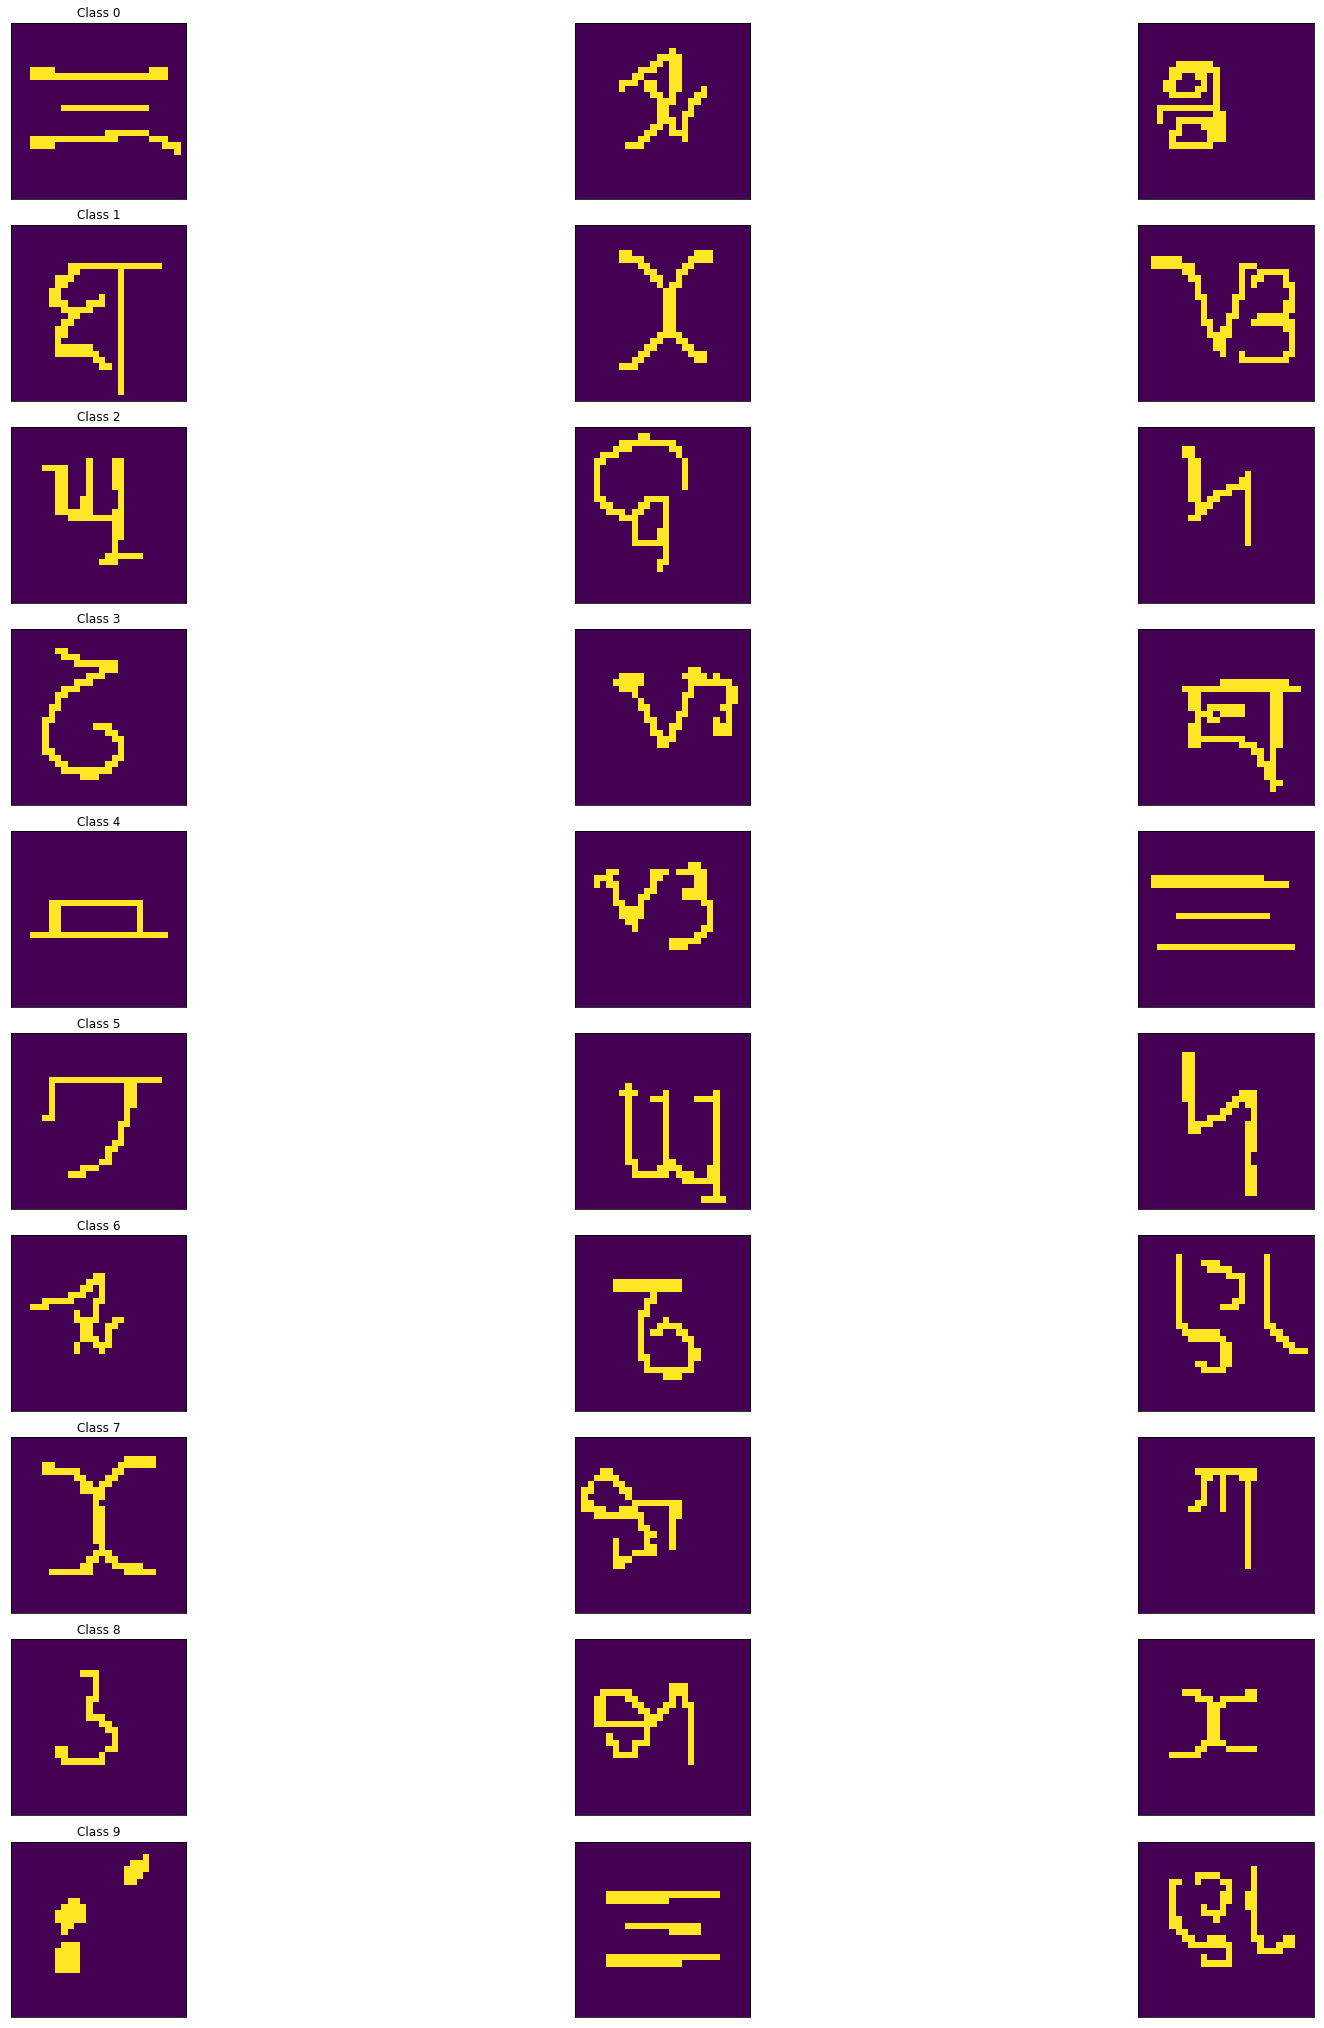

In [26]:
%matplotlib inline
f, axarr = plt.subplots(10, 3, figsize=(28,28), sharex='all', sharey='all')
for i in range(10):
    #print("Class: ", labels[0,0,i])
    #plt.imshow(images[0,0,i].reshape((28,28)))
    axarr[i,0].set_title("Class {}".format(i))
    axarr[i,0].imshow(images[0,0,i].reshape((28,28)))
    axarr[i,1].imshow(images[0,1,i].reshape((28,28)))
    axarr[i,2].imshow(images[0,2,i].reshape((28,28)))

plt.xticks([], [])
plt.yticks([], [])
plt.tight_layout(pad=0.1)
f.subplots_adjust(hspace=0.15)

plt.show()

In [27]:
print("# samples per class:", data.num_samples_per_class)
print("# classes:",  data.num_classes)
print("Image size:", data.img_size)
print("Input dimension:", data.dim_input)
print("Output dimension:",data.dim_output)


# samples per class: 3
# classes: 20
Image size: (28, 28)
Input dimension: 784
Output dimension: 20


In [ ]:
print("# of meta train folders:", len(data.metatrain_character_folders))
print("# of meta val folders:  ", len(data.metaval_character_folders))
print("# of meta test folders: ", len(data.metatest_character_folders))

In [ ]:
data.metatrain_character_folders[0:10]

In [ ]:
data.metatest_character_folders[0:3]

In [ ]:
get_images(data.metatest_character_folders[0:3],['asd','N_Ko','Glagolitic'],1)

In [ ]:
[os.path.basename(os.path.split(family)[0]) for family in data.metatest_character_folders[0:3]]

In [ ]:
plt.imshow(image_file_to_array('./omniglot_resized/N_Ko/character12/0815_17.png', 784).reshape((28,28)))

# b)

In [30]:
#import numpy as np
#import random
import tensorflow as tf
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()
#from load_data import DataGenerator
#from tensorflow.keras import layers

In [31]:
tf.__version__

'1.15.0'

In [ ]:
# Number of classes used in classification (e.g. 5-way classification).
num_classes = 20 

# Number of examples used for inner gradient update (K for K-shot learning)
num_samples = 1

# Number of N-way classification tasks per batch
meta_batch_size = 4

def loss_function(preds, labels):
    """l
    Computes MANN loss
    Args:
        preds: [B, K+1, N, N] network output
        labels: [B, K+1, N, N] labels
    Returns:
        scalar loss
    """
    #############################
    #### YOUR CODE GOES HERE ####
    #bce  = tf.keras.losses.BinaryCrossentropy()
    #labels = tf.reshape(labels, tf.TensorShape(new_shape))
    #loss = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=preds)
    loss = tf.keras.losses.categorical_crossentropy(y_true=labels[:,-1:,:,:], y_pred=preds[:,-1:,:,:], from_logits=True)
    loss = tf.reduce_mean(loss)
    #############################
    return loss

class MANN(tf.keras.Model):

    def __init__(self, num_classes, samples_per_class):
        super(MANN, self).__init__()
        self.num_classes = num_classes
        self.samples_per_class = samples_per_class
        self.layer1 = tf.keras.layers.LSTM(128, return_sequences=True)
        self.layer2 = tf.keras.layers.LSTM(num_classes, return_sequences=True)

    def call(self, input_images, input_labels):
        """
        MANN
        Args:
            input_images: [B, K+1, N, 784] flattened images
            labels:       [B, K+1, N, N] ground truth labels
        Returns:
            [B, K+1, N, N] predictions
        """
        #############################
        #### YOUR CODE GOES HERE ####
        # Data processing as in SNAIL
        _,K,N,I = input_images.shape
        # First K data+labels (for each N classes)
        data1 = tf.concat([input_images[:,0:-1,:,:],
                           input_labels[:,0:-1,:,:]], axis=3)
        # Last N examples of data+zeros 
        data2 = tf.concat([input_images[:,-1:,:,:],
                           tf.zeros_like(input_labels)[:,-1:,:,:]], axis=3)
        data = tf.concat([data1, data2], axis=1)
        data = tf.reshape(data, [-1, K*N, I+N])
        # Pass data through network
        x = self.layer1(data)#[i,:,:,:])
        x = self.layer2(x)
        # Return original shape [B,K+1,N,N]
        out = tf.reshape(x, [-1, K, N, N])
        #############################
        return out

#Placeholders for images and labels
ims = tf.placeholder(tf.float32,
            shape=(None,
                   num_samples + 1,
                   num_classes,
                   784))
labels = tf.placeholder(tf.float32,
            shape=(None,
                   num_samples + 1,
                   num_classes,
                   num_classes))

data_generator = DataGenerator(
                    num_classes,
                    num_samples + 1)

o = MANN(num_classes, num_samples + 1)
out = o(ims, labels)

loss = loss_function(out, labels)
print("...tf.trainable_variables():",tf.trainable_variables())

optim = tf.train.AdamOptimizer(0.001)
#optim = tf.compat.v1.train.AdamOptimizer(0.001)
optimizer_step = optim.minimize(loss)
print("...Starts training...")
with tf.Session() as sess:
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    
    for step in range(50000):
        i, l = data_generator.sample_batch(batch_type='train', batch_size=meta_batch_size)
        #print("i.shape:",i.shape)
        feed = {ims:    i.astype(np.float32),
                labels: l.astype(np.float32)}
        #print("feed[ims].shape:", feed[ims].shape)
        _, ls = sess.run([optimizer_step, loss], feed)

        if step % 100 == 0:
            print("*" * 5 + "Iter " + str(step) + "*" * 5)
            i, l = data_generator.sample_batch(batch_type='test', batch_size=100)
            feed = {ims:    i.astype(np.float32),
                    labels: l.astype(np.float32)}
            pred, tls = sess.run([out, loss], feed)
            print("Train Loss:", ls, "Test Loss:", tls)
            pred = pred.reshape(
                    -1, num_samples + 1,
                    num_classes, num_classes)
            pred = pred[:, -1, :, :].argmax(2)
            l = l[:, -1, :, :].argmax(2)
            print("Test Accuracy", (1.0 * (pred == l)).mean())


Data generator initialized. Shape: [B, 2, 20, 784]
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
...tf.trainable_variables(): [<tf.Variable 'mann/lstm/kernel:0' shape=(804, 512) dtype=float32>, <tf.Variable 'mann/lstm/recurrent_kernel:0' shape=(128, 512) dtype=float32>, <tf.Variable 'mann/lstm/bias:0' shape=(512,) dtype=float32>, <tf.Variable 'mann/lstm_1/kernel:0' shape=(128, 80) dtype=float32>, <tf.Variable 'mann/lstm_1/recurrent_kernel:0' shape=(20, 80) dtype=float32>, <tf.Variable 'mann/lstm_1/bias:0' shape=(80,) dtype=float32>]
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
...Starts training...
*****Iter 0*****
Train Loss: 2.9977787 Test Loss: 2.9984438
Test Accuracy 0.0525
*****Iter 100*****
Train Loss: 2.1148918 Test Loss: 2.0516994
Test Accuracy 0.3265
*****Iter 200*****
Train Loss: 1.9955387 Test Loss: 2.0412745
Test Accuracy 0.2085
*****Iter 300*****
Train Loss: 1.8380032 Test Loss: 1.8258033
T